In [30]:
library("devtools")
install_github("felixfan/FinCal")

Skipping install of 'FinCal' from a github remote, the SHA1 (3573a714) has not changed since last install.
  Use `force = TRUE` to force installation



In [31]:
# load library
library(rvest)
library(ggplot2)
library(FinCal)

In [32]:
# Custom Functions
convert <- function(x) {
  x <- gsub('[(]',"-",x)
  x <- gsub('[)]',"",x)
  if (grepl("B", x)) {
    x <- gsub('[B]',"",x) 
    x <- as.double(x)
    x*1000
  } else if (grepl("M", x)) {
    x <- gsub('[M]',"",x)
    x <- as.double(x) 
    x*1
  } else if (grepl("-", x)) {
    x <- gsub('-',"0",x)
    x <- as.double(x)
  }
}

graph <- function(data,col,ylabel) {
    ggplot(df, aes(year,data)) +
      geom_bar(stat="identity", fill = col, color = "black", alpha = 0.8) +
      geom_smooth(method=lm, se=FALSE, size=2) +
      geom_text(aes(label=data), vjust = -0.3) +
      ylab(ylabel)
}

In [33]:
stock <- readline(prompt="Enter stock ticker: ")

Enter stock ticker:  aapl


In [34]:
# Scrape Financial data
income_statement <- paste0('https://www.marketwatch.com/investing/stock/',stock,'/financials')
income_statement_page <- income_statement %>% read_html()
balance_sheet <- paste0('https://www.marketwatch.com/investing/stock/',stock,'/financials/balance-sheet')
balance_sheet_page <- balance_sheet %>% read_html()
cash_flow <- paste0('https://www.marketwatch.com/investing/stock/',stock,'/financials/cash-flow')
cash_flow_page <- cash_flow %>% read_html()
more_stats <- paste0("https://finviz.com/quote.ashx?t=",stock)
more_stats_page <- more_stats %>% read_html()

income_names <- income_statement_page %>% html_nodes(".overflow__cell .fixed--cell") %>% html_text()
income_nums <- income_statement_page %>% html_nodes(".cell__content span") %>% html_text()
balance_names <- balance_sheet_page %>% html_nodes(".overflow__cell .fixed--cell") %>% html_text()
balance_nums <- balance_sheet_page %>% html_nodes(".cell__content span") %>% html_text()
cash_names <- cash_flow_page %>% html_nodes(".overflow__cell .fixed--cell") %>% html_text()
cash_nums <- cash_flow_page %>% html_nodes(".cell__content span") %>% html_text()
stats_names <- more_stats_page %>% html_nodes(".snapshot-td2-cp") %>% html_text()
stats_nums <- more_stats_page %>% html_nodes(".snapshot-td2 b") %>% html_text()

x<-1
while (income_names[x] != "Sales/Revenue") {x<-x+1}
Revenue <- income_nums[(5*(x-1)+1):(5*x)]
for(i in 1:5){
  Revenue[i] <- convert(Revenue[i])
}
Revenue <- as.numeric(Revenue)
x<-1
while (income_names[x] != "Net Income") {x<-x+1}
Net_Income <- income_nums[(5*(x-1)+1):(5*x)]
for(i in 1:5){
  Net_Income[i] <- convert(Net_Income[i])
}
Net_Income <- as.numeric(Net_Income) 
x<-1
while (balance_names[x] != "Total Equity") {x<-x+1}
Equity <- balance_nums[(5*(x-1)+1):(5*x)]
for(i in 1:5){
  Equity[i] <- convert(Equity[i])
}
Equity <- as.numeric(Equity)
x<-1
while (balance_names[x] != "Long-Term Debt") {x<-x+1}
Debt <- balance_nums[(5*(x-1)+1):(5*x)]
for(i in 1:5){
  Debt[i] <- convert(Debt[i])
}
Debt <- as.numeric(Debt)
x<-1
while (cash_names[x] != "Net Operating Cash Flow") {x<-x+1}
Operating_Cash <- cash_nums[(5*(x-1)+1):(5*x)]
for(i in 1:5){
  Operating_Cash[i] <- convert(Operating_Cash[i])
}
Operating_Cash <- as.numeric(Operating_Cash)
ROIC <- c()
for(i in 1:5) {
  x <- Net_Income[i]/(Equity[i] + Debt[i]) 
  ROIC <- append(ROIC,round(x,2))
}
ROE <- c()
for(i in 1:5) {
  x <- Net_Income[i]/Equity[i]
  ROE <- append(ROE,round(x,2))
}
df <- data.frame (
  year = 1:5,
  Revenue = Revenue,
  Net_Income = Net_Income, 
  Debt = Debt ,
  Equity = Equity,
  Operating_Cash = Operating_Cash,
  ROIC = ROIC,
  ROE = ROE
)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


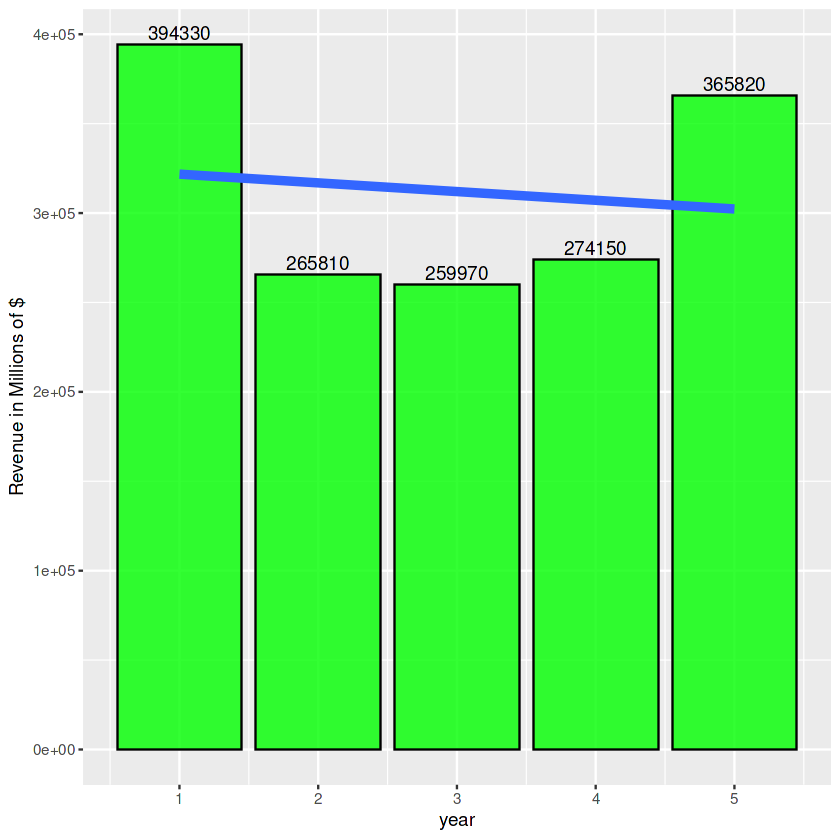

`geom_smooth()` using formula = 'y ~ x'


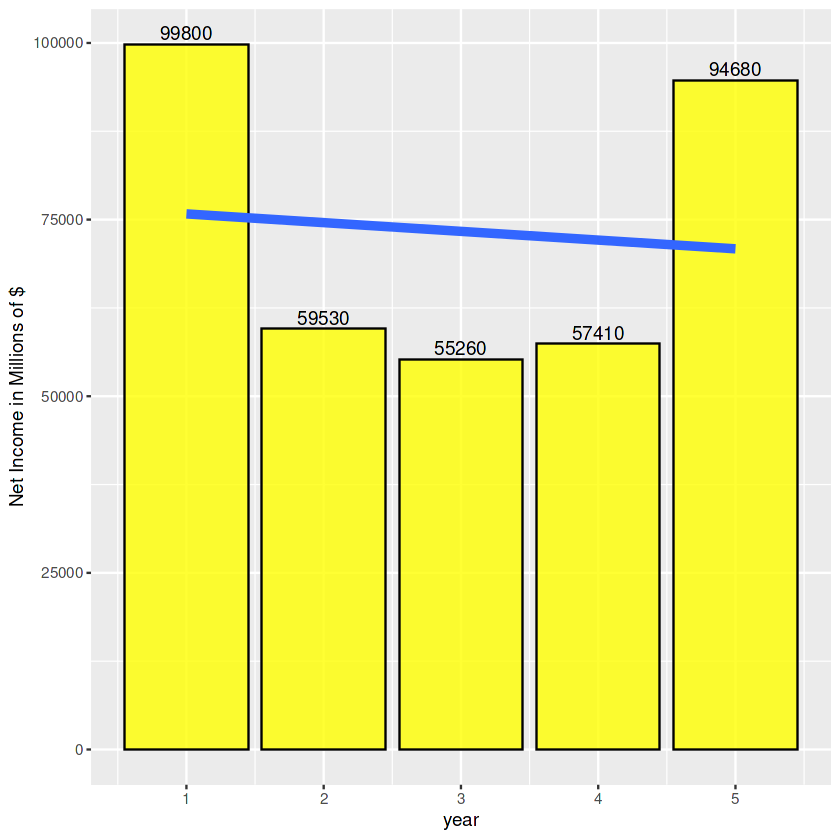

`geom_smooth()` using formula = 'y ~ x'


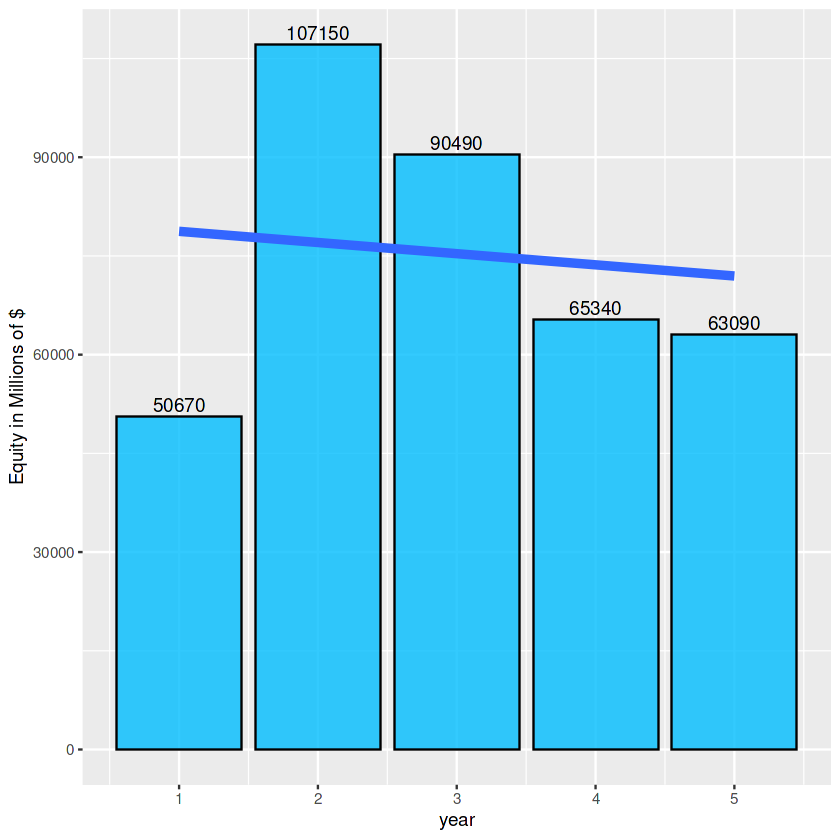

`geom_smooth()` using formula = 'y ~ x'


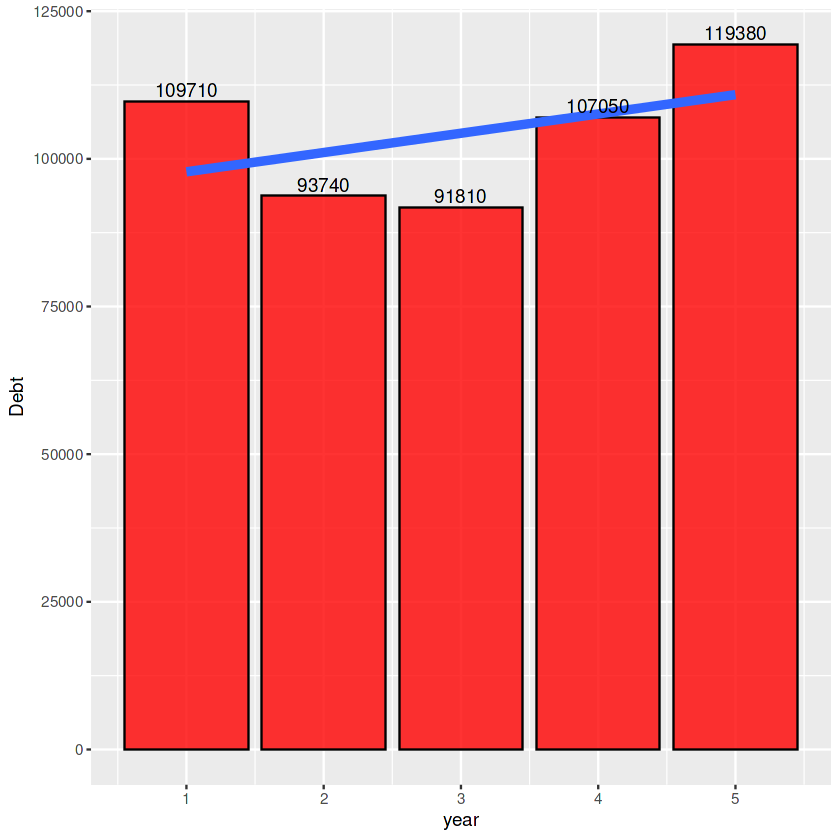

`geom_smooth()` using formula = 'y ~ x'


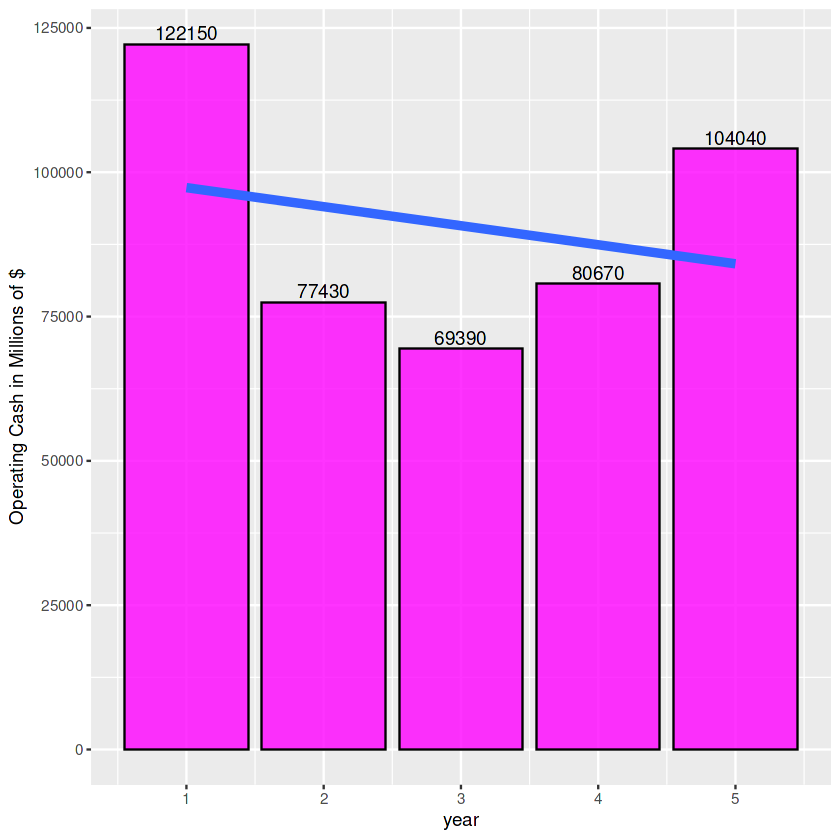

`geom_smooth()` using formula = 'y ~ x'


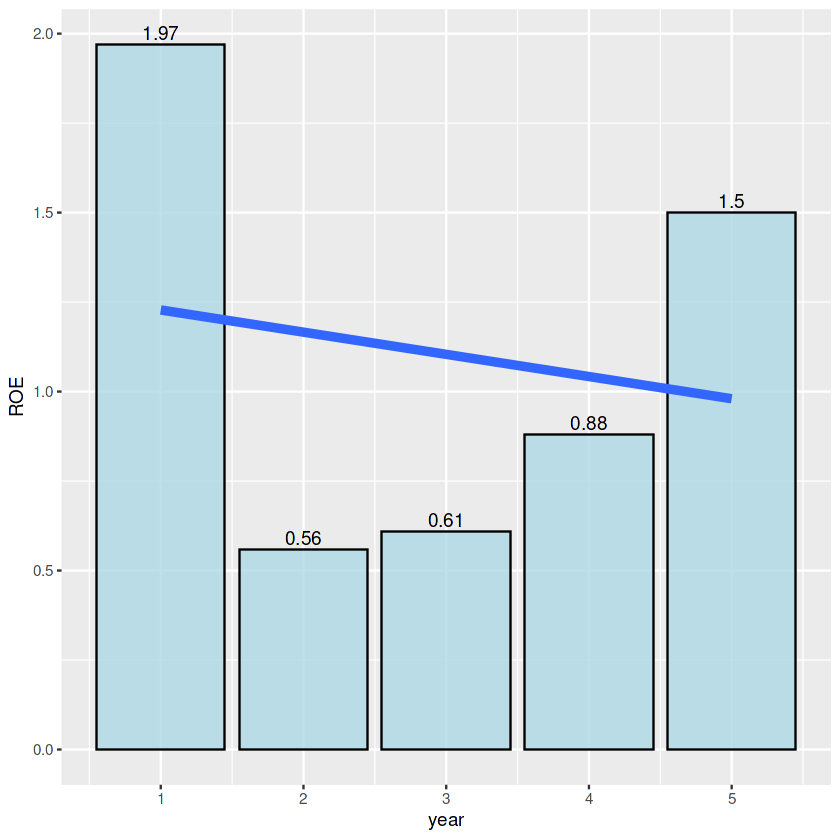

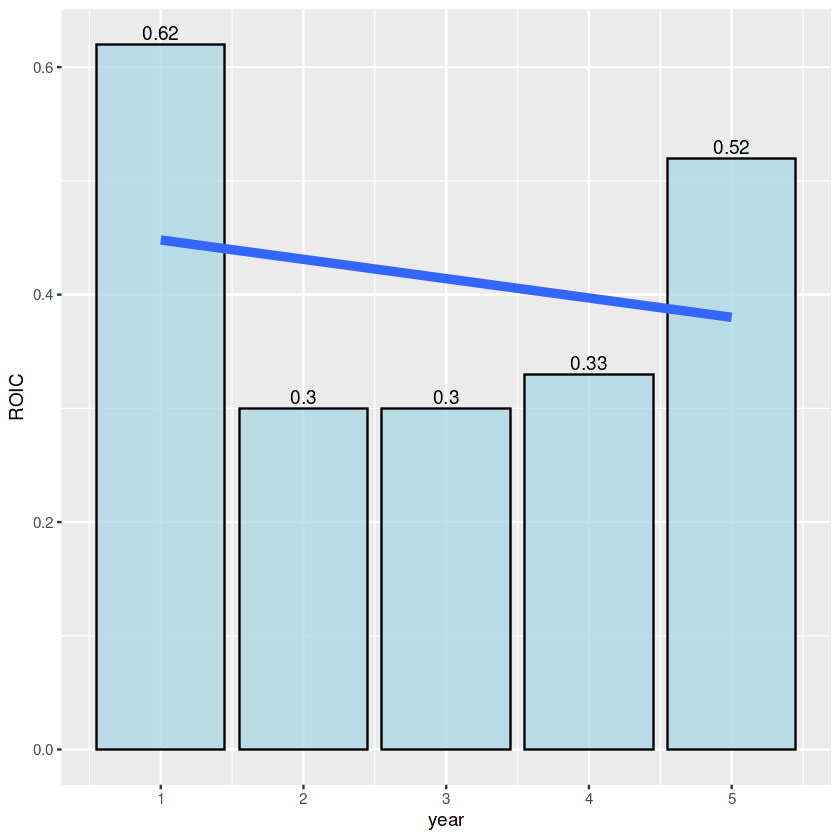

In [35]:
# Graph of financial data with trendline
graph(Revenue, "green","Revenue in Millions of $")

graph(Net_Income, "yellow","Net Income in Millions of $")

graph(Equity,  "#00BDFE", "Equity in Millions of $")

graph(Debt,"red", "Debt")

graph(Operating_Cash, "magenta", "Operating Cash in Millions of $")

graph(ROE,"lightblue", "ROE")

graph(ROIC,"lightblue", "ROIC")


In [36]:
proj_growth <- as.numeric(readline(prompt = "Enter projected growth rate: "))

Enter projected growth rate:  .18


In [37]:
# Scrape valuation data
x<-1
while (income_names[x] != "EPS (Basic)") {x<-x+1}
EPS <- income_nums[(5*x)]
EPS <- as.double(EPS)
x<-1
while (stats_names[x] != "P/E") {x<-x+1}
PE <- stats_nums[x] %>% as.double()
x<-1
while (stats_names[x] != "Price") {x<-x+1}
price <- stats_nums[x] %>% as.double()
x<-1
while (stats_names[x] != "Shs Outstand") {x<-x+1}
shares <- stats_nums[x] %>% convert()
x<-1
while (cash_names[x] != "Free Cash Flow") {x<-x+1}
FCF <- cash_nums[(5*x)]
FCF <- convert(FCF)
FCF <- as.numeric(FCF)/shares

In [38]:
#Valuation
a <- FCF
for (i in 1:8) {
  a[i+1] <- a[i]+a[i]*proj_growth
}
BuyPrice1 <- sum(a)-a[1]
Future_Value <- fv(proj_growth,10,-EPS)*25 # expected value 10 years from now
Present_Value <- pv(proj_growth,10,-Future_Value) # what it's worth today
BuyPrice2 <- Present_Value/2 # safety margin
cat("Stock: ", stock," Current Price: ", price," Buy Prices: ",round(BuyPrice1,2),";",round(BuyPrice2,2),".",sep="")

Stock: aapl Current Price: 147.41 Buy Prices: 105.79;70.88.